In [148]:
import pandas as pd
import numpy as np
import json 
import seaborn as sns
from pylab import mpl, plt

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

In [229]:
def rango_percentilar(mydata, col_name, idx):
    return np.mean(mydata[f"{col_name}"].to_numpy() <= mydata[f"{col_name}"].iloc[idx])


def to_percentile(mydata, col_name):
    mydata = mydata.copy()
    mydata = mydata.reset_index()
    percentiles = [ ]
    for idx, series in mydata.iterrows():
        res = rango_percentilar(mydata, col_name, idx)
        percentiles.append(res)
    mydata[f"{col_name}_percentile"] = percentiles
    return mydata


def plot_mayer(mydata, x="time", y="price", hue="Mayer_percentile"):
    f, ax = plt.subplots(figsize=(15, 11))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x="time", y="price",
                    hue="Mayer_percentile", 
                    sizes=(10, 20),
                    alpha=.5,
                    palette="rocket", 
                    data=mydata, ax=ax)


<AxesSubplot:xlabel='time'>

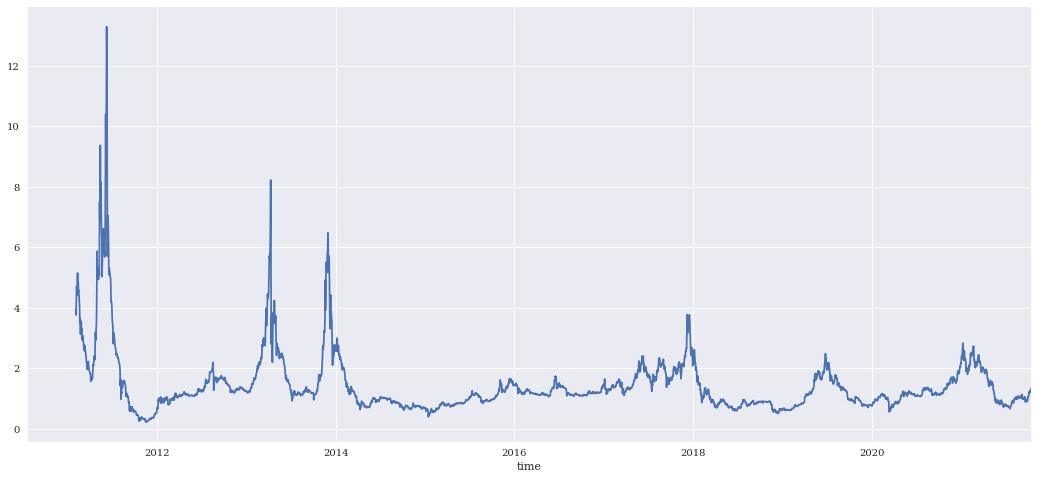

In [151]:
df = pd.read_json('./price-btc-24h.json')

df.columns = ["time", "price"]
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)

# Mayer multpliyer
df['SMA_200'] = df['price'].rolling(200).mean()
df["Mayer"] = (df["price"])/df["SMA_200"]
df["Mayer"].plot.line( figsize=(18,8))

<AxesSubplot:xlabel='Mayer', ylabel='Count'>

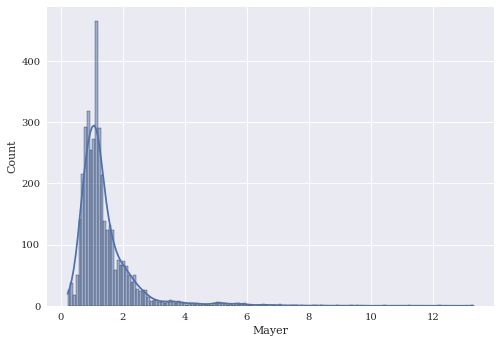

In [153]:
seaborn.histplot(df["Mayer"],kde=True )

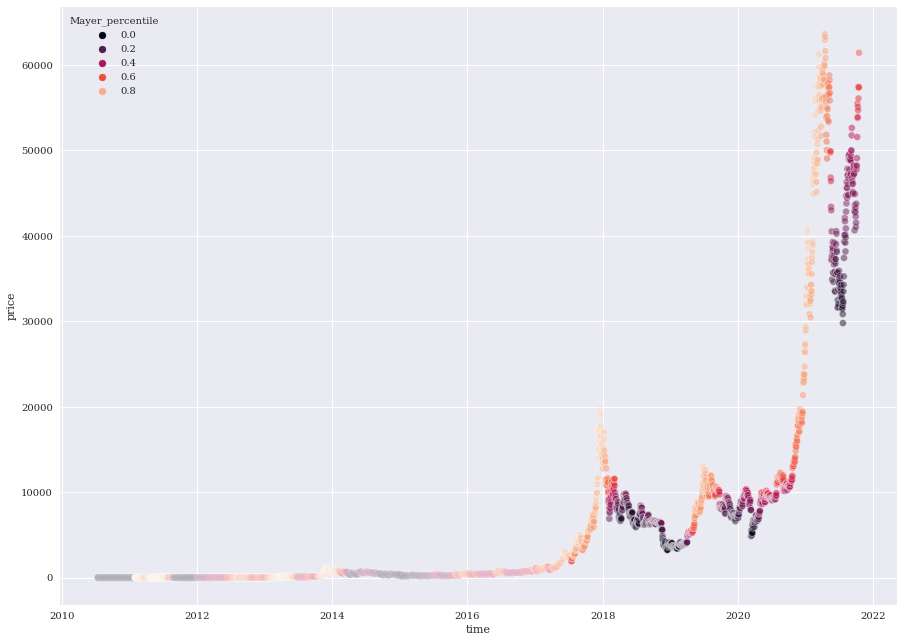

In [230]:
plot_mayer(df)  

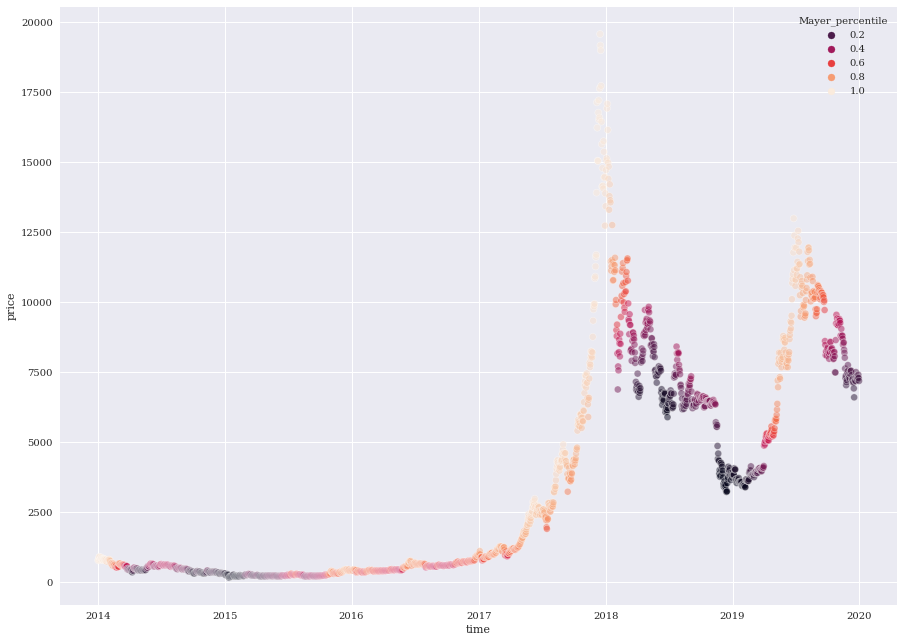

In [232]:
# Mayor a 2014
data = df[df.time>"2014-01-01"]

# partición train y test
fecha_part = "2020-01-01"
train = data[data.time<fecha_part]
train = to_percentile(train, "Mayer")
test = data[data.time>=fecha_part]

plot_mayer(train)

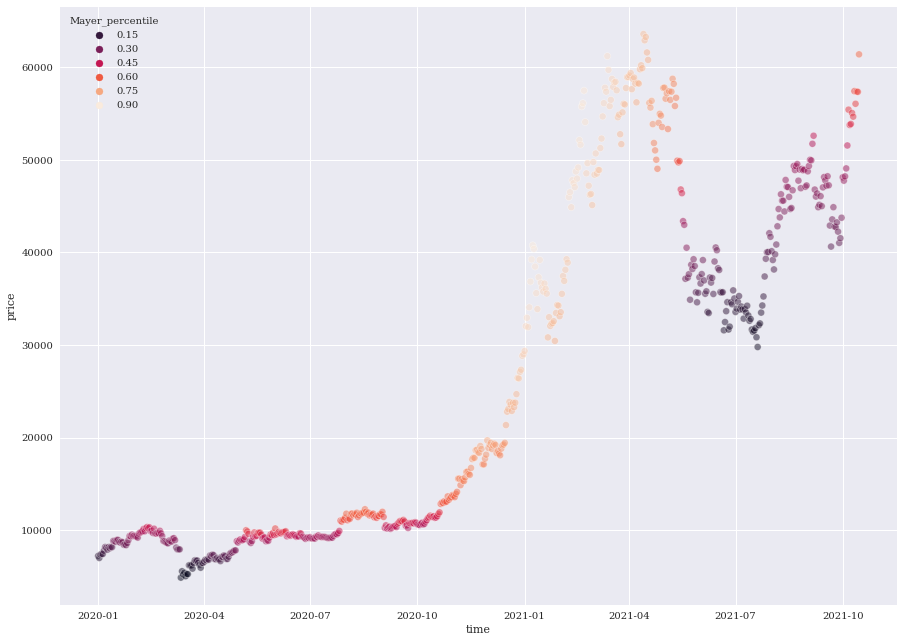

In [233]:
plot_mayer(test)

## Training
----

### Vectorización 

In [268]:
 data['position'] = np.where(data['Mayer_percentile'] > 0.72, 0, 1) 
    

<ipython-input-268-927c08c55558>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['position'] = np.where(data['Mayer_percentile'] > 0.72, 0, 1)


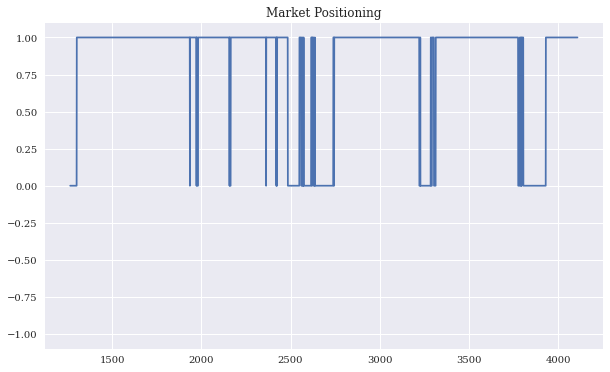

In [269]:
analisis = data.dropna() 
data['position'].plot(ylim=[-1.1, 1.1],
 title='Market Positioning',
figsize=(10, 6));     

In [270]:
 analisis['returns'] = np.log(data['price'] / data['price'].shift(1)) 

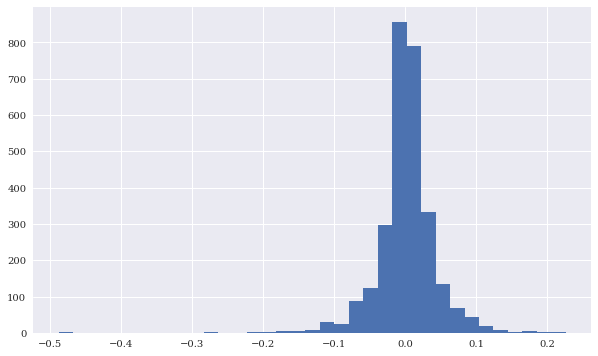

In [271]:
analisis['returns'].hist(bins=35, figsize=(10, 6)); 

In [272]:
analisis['strategy'] = analisis['position'].shift(1) * analisis['returns'] 
analisis[['returns', 'strategy']].sum() 
analisis[['returns', 'strategy']].sum().apply(np.exp) 

returns     78.297146
strategy    16.710741
dtype: float64

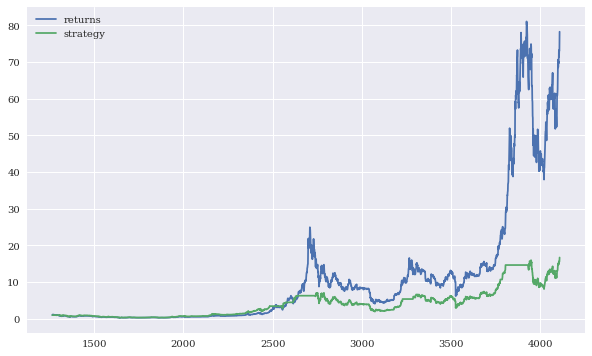

In [273]:
analisis[['returns', 'strategy']].cumsum(
 ).apply(np.exp).plot(figsize=(10, 6));

In [274]:
analisis[['returns', 'strategy']].mean() * 252

returns     0.386510
strategy    0.249611
dtype: float64